In [2]:
import pandas as pd
import json

In [3]:
# Load the data about businesses
biz_file = open('yelp_academic_dataset_business.json')

FileNotFoundError: [Errno 2] No such file or directory: 'yelp_academic_dataset_business.json'

In [ ]:
biz_df = pd.DataFrame([json.loads(x) for x in biz_file.readlines()])

In [ ]:
biz_df 

In [4]:
biz_file.close()

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Occurrence')

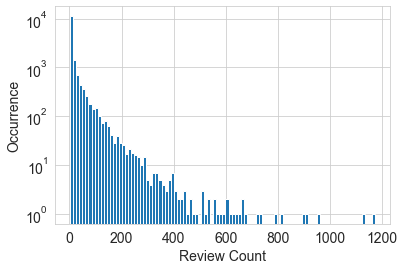

In [6]:
#Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
biz_df['review_count'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Review Count', fontsize=14)
ax.set_ylabel('Occurrence', fontsize=14)

Los recuentos sin procesar (brutos) que abarcan varios órdenes de magnitud son problemáticos para muchos modelos. En un modelo lineal, el mismo coeficiente lineal tendría que funcionar para todos los valores posibles del recuento. Los recuentos grandes también podrían causar estragos en los métodos de aprendizaje no supervisados, como el agrupamiento de k-medias, que utiliza la distancia euclidiana como función de similitud para medir la similitud entre puntos de datos. Un recuento grande en un elemento del vector de datos superaría la similitud en todos los demás elementos, lo que podría desechar toda la medición de similitud.

Una solución es contener la escala cuantificando el recuento. En otras palabras, agrupamos los recuentos en contenedores y nos deshacemos de los valores de recuento reales. La cuantificación asigna un número continuo a uno discreto. Podemos pensar en los números discretizados como una secuencia ordenada de contenedores que representan una medida de intensidad.

Para cuantificar los datos, tenemos que decidir **qué tan ancho debe ser cada contenedor.** Las soluciones se dividen en dos categorías: **de ancho fijo o adaptativas (fixed-width or adaptive).** Daremos un ejemplo de cada tipo.

# Fixed-width binning

Con la agrupación de ancho fijo, cada bandeja contiene un rango numérico específico. Los rangos se pueden diseñar a medida o segmentar automáticamente, y se pueden escalar linealmente o exponencialmente. Por ejemplo, podemos agrupar a las personas en rangos de edad por década: 0 a 9 años en el contenedor **(bin)** 1, 10 a 19 años en el contenedor 2, etc. Para mapear desde el recuento hasta el contenedor, simplemente dividimos por el ancho del contenedor. y toma la parte entera.

También es común ver rangos de edad diseñados a medida que se corresponden mejor con las etapas de la vida, como: 0-12 años,
12-17 años,
18-24 años,
25 a 34 años,
35 a 44 años,
45 a 54 años,
55 a 64 años,
65 a 74 años,
75 años o más.

Cuando los números abarcan múltiples magnitudes, puede ser mejor agrupar por potencias de 10 (o potencias de cualquier constante): 0–9, 10–99, 100–999, 1000–9999, etc. Los anchos de intervalo crecen exponencialmente, yendo de O (10), a O (100), O (1000) y más allá. Para mapear desde el recuento al contenedor, tomamos el registro del recuento. El agrupamiento de ancho exponencial está muy relacionado con la **transformación logarítmica "Log Transformation"** El siguiente ejemplo ilustra varios de estos métodos de agrupamiento.

In [8]:
import numpy as np

In [9]:
# Generate 20 random integers uniformly between 0 and 99
small_counts = np.random.randint(0, 100, 20)
small_counts

array([51, 21, 93, 39, 42, 19, 44, 33, 27, 68, 83, 79,  6, 90, 13, 13, 73,
        5,  3, 40])

In [10]:
# Map to evenly spaced bins 0-9 by division
np.floor_divide(small_counts, 10)

array([5, 2, 9, 3, 4, 1, 4, 3, 2, 6, 8, 7, 0, 9, 1, 1, 7, 0, 0, 4],
      dtype=int32)

In [15]:
# An array of counts that span several magnitudes
large_counts = [296, 8286, 64011, 80, 3, 725, 867, 2215, 7689, 11495,
91897,44, 28, 7971, 926, 122, 22222]

In [16]:
# Map to exponential-width bins via the log function
np.floor(np.log10(large_counts))

array([2., 3., 4., 1., 0., 2., 2., 3., 3., 4., 4., 1., 1., 3., 2., 2., 4.])

# Quantile binning

El agrupamiento de ancho fijo es fácil de calcular. Pero si hay grandes lagunas en los recuentos, habrá muchos contenedores vacíos sin datos. Este problema se puede resolver colocando de forma adaptativa los contenedores en función de la distribución de los datos. Esto se puede hacer utilizando los cuantiles de la distribución.

Los cuantiles son valores que dividen los datos en porciones iguales. Por ejemplo, la mediana divide los datos en mitades; la mitad de los puntos de datos son más pequeños y la mitad más grandes que la mediana. Los cuartiles dividen los datos en cuartos, los deciles en décimas, etc.

In [17]:
deciles = biz_df['review_count'].quantile([.1, .2, .3, .4, .5, .6, .7, .8,.9])

In [18]:
deciles

0.1     3.0
0.2     3.0
0.3     4.0
0.4     5.0
0.5     6.0
0.6     8.0
0.7    13.0
0.8    24.0
0.9    56.0
Name: review_count, dtype: float64

Text(0, 0.5, 'Occurrence')

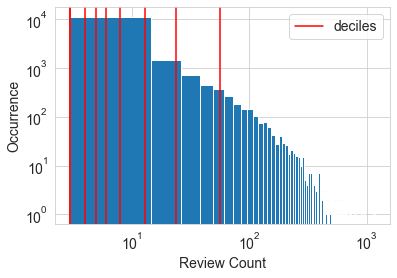

In [19]:
#Visualize the deciles on the histogram
sns.set_style('whitegrid')
fig, ax = plt.subplots()
biz_df['review_count'].hist(ax=ax, bins=100)
for pos in deciles:
    handle = plt.axvline(pos, color='r')
ax.legend([handle], ['deciles'], fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Review Count', fontsize=14)
ax.set_ylabel('Occurrence', fontsize=14)

Para calcular los cuantiles y mapear datos en contenedores de cuantiles, podemos usar la biblioteca Pandas.

In [20]:
import pandas as pd

In [21]:
# Map the counts to quartiles
pd.qcut(large_counts, 4, labels=False)

array([1, 2, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 2, 1, 0, 3], dtype=int64)

In [22]:
# Compute the quantiles themselves
large_counts_series = pd.Series(large_counts)

In [23]:
large_counts_series.quantile([0.25, 0.5, 0.75])

0.25     122.0
0.50     926.0
0.75    8286.0
dtype: float64